In [1]:
import pandas as pd
import os
import numpy as np
import re
from tqdm import tqdm
import gensim
from scipy.sparse import csr_matrix, save_npz,load_npz
from data_process import spec
from data_process.spec_to_wordvector import spec_to_wordvector

In [2]:
# Ten measured spectra were transformered to spectra.mgf
spectrums=[]
all_files = os.listdir('data/query spectra/')
for i in range(len(all_files)):
    f = 'data/query spectra/' + all_files[i]
    mz=[]
    inten=[]  
    data=pd.read_csv(f,header=None)
 
    for j in range(len(data[0])):
        mz.append(float(round(float(data[0][j]))))
        inten.append(float(data[1][j]))
        M=np.array(mz)
        I=np.array(inten)
        I/= max(I)
                #delete noise
        keep = np.where(I > 0.001)[0]
        M = M[keep]
        I = I[keep]

    if max(M)>1500:
        continue
    else:                
        spectrum = spec.Spectrum(mz=M,intensities=I,
                                metadata={'compound_name': 'substance_measured'+str(all_files[i])})
        spectrums.append(spectrum)

In [4]:
spec.save_as_mgf(spectrums, 'data/meassured_spectra.mgf') 

In [5]:
 # Load pretrained model to transformer spectra.mgf to spectra Word2vec embeddings
model_file ="model/references_word2vec.model"
       
model = gensim.models.Word2Vec.load(model_file)
spectovec = spec_to_wordvector(model=model, intensity_weighting_power=0.5)
wordembeddings=[]
spectrums = [s for s in spectrums if s is not None]
for i in tqdm(range(len(spectrums))):
    spectrum_in = spec.SpectrumDocument(spectrums[i], n_decimals=0)
    embedding=spectovec._calculate_embedding(spectrum_in)
    wordembeddings.append(embedding)
spectra_embeddings=csr_matrix(np.array(wordembeddings))
save_npz('data/meassured_spectra_embeddings.npz',spectra_embeddings)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 569.54it/s]


In [6]:
# load HNSW index for matching
import time
import hnswlib
import pickle
xq= spectra_embeddings.todense().astype('float32')
xq_len = np.linalg.norm(xq, axis=1, keepdims=True)
xq = xq/xq_len
dim = 500
start_time=time.time()*1000
p = hnswlib.Index(space='l2', dim=dim) 
p.load_index("data/references_index.bin", max_elements =2343378)
end_time=time.time()*1000
print('loadindex_time %.4f'%((end_time-start_time)/1000)+ ' s')
import time
start_time=time.time()*1000
# Controlling the recall by setting ef:
p.set_ef(300) # ef should always be > k   ##
# Query dataset, k - number of closest elements (returns 2 numpy arrays)
k=100
I, D = p.knn_query(xq, k)
end_time=time.time()*1000
print('search_time %.4f'%((end_time-start_time)/1000)+ ' s')

np.save('data/10compounds_index_results.npy',I)
np.save('data/10compounds_score_results.npy',D)

loadindex_time 29.6697 s
search_time 0.1034 s


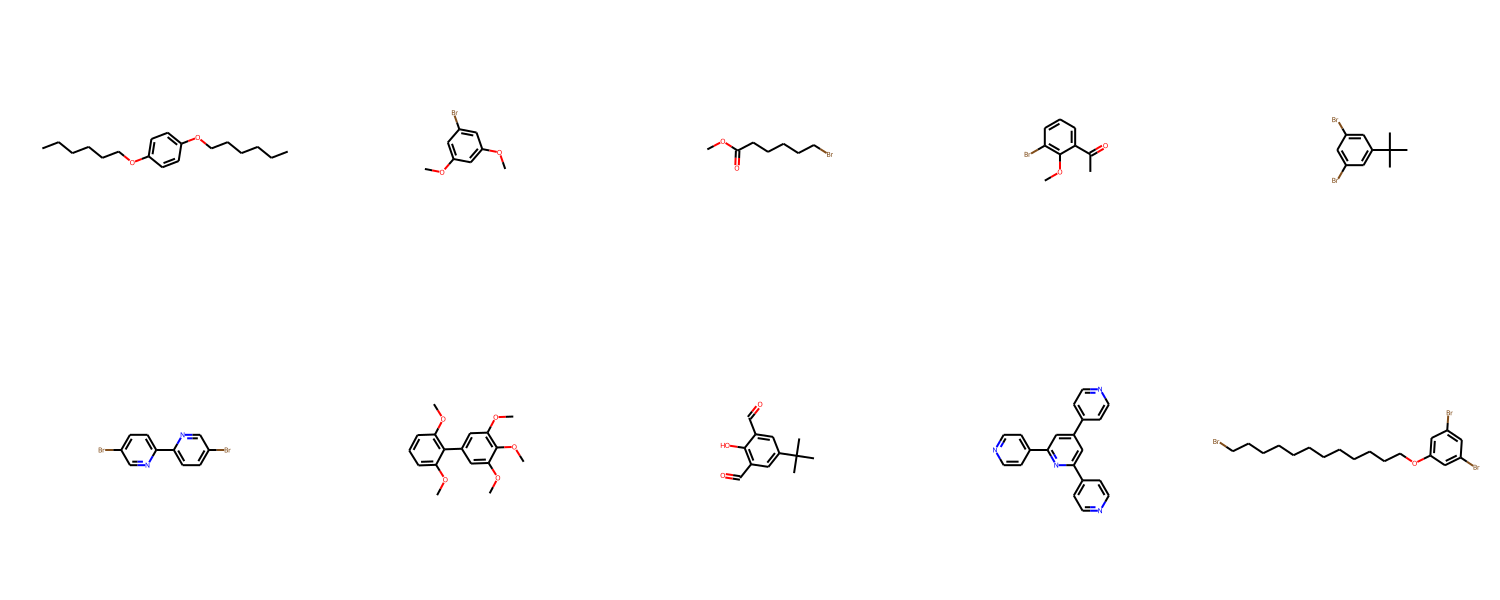

In [7]:
# load ten compounds’SMILES and draw their structure
df=pd.read_csv('data/extral_test_10compounds_SMILES.csv')
smiles=list(df['smiles'])
from rdkit import Chem
from rdkit.Chem import  Draw
mols = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300,300))

[('IN_SILICO_LIBRARY',)]


2343378it [01:09, 33851.91it/s]


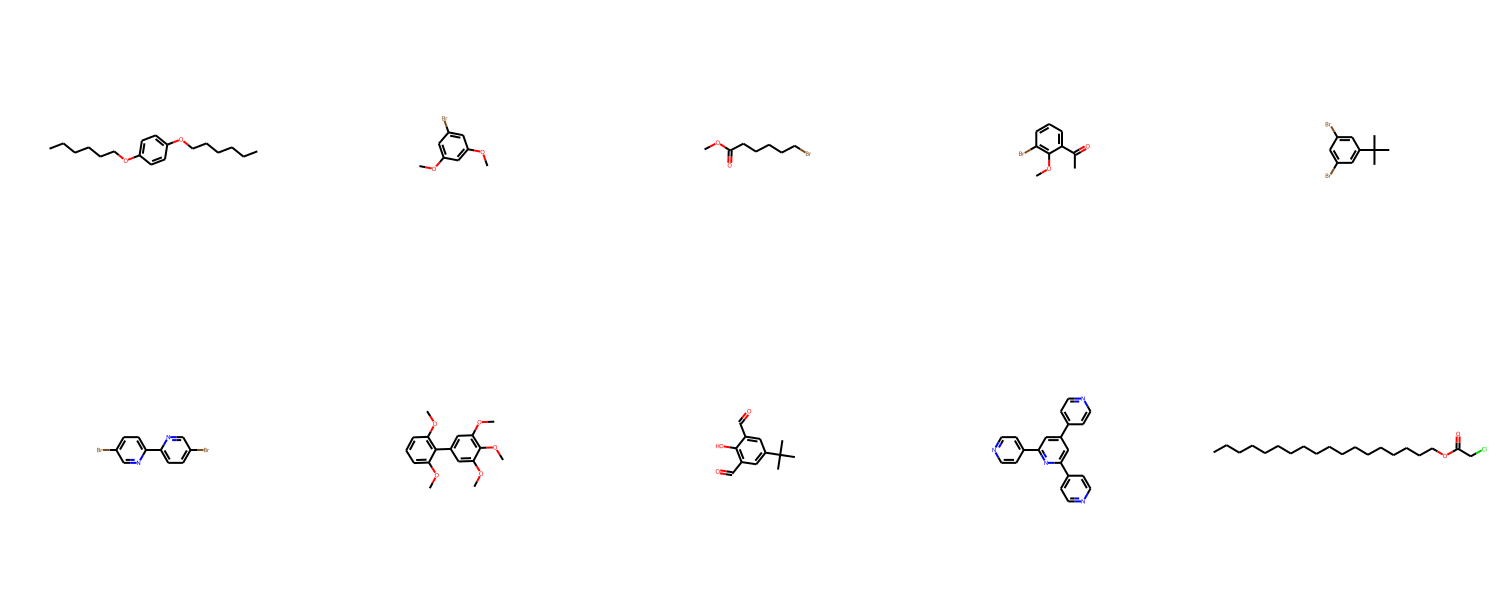

In [9]:
#According to matching index to find matching molecules from IN_SILICO_LIBRARY.db
import sqlite3
gradedb = sqlite3.connect("data/IN_SILICO_LIBRARY.db")
cursor=gradedb.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
Tables=cursor.fetchall()
print(Tables)
content = cursor.execute("SELECT COMPID, SMILES, MZS,INTENSITYS from IN_SILICO_LIBRARY")
# Indexing of target compounds, except for compound J
matching_index=[I[0][0],I[1][0],I[2][0],I[3][0],I[4][0],I[5][1],I[6][8],I[7][14],I[8][17],I[9][99]]
all_smiles=[]
for row in tqdm(cursor):
    all_smiles.append(row[1])
matching_smiles=[all_smiles[i] for i in matching_index]
# Draw matching compounds' structure
mols = [Chem.MolFromSmiles(x) for x in matching_smiles]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300,300))